# Multi-fidelity Multi-objective Bayesian Optimization

Here we attempt to solve for the constrained Pareto front of the TNK multi-objective
optimization problem using Multi-Fidelity Multi-Objective Bayesian optimization. For
simplicity we assume that the objective and constraint functions at lower fidelities is
exactly equal to the functions at higher fidelities (this is obviously not a
requirement, although for the best results lower fidelity calculations should
correlate with higher fidelity ones). The algorithm should learn this relationship
and use information gathered at lower fidelities to gather samples to improve the
hypervolume of the Pareto front at the maximum fidelity.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
%reset -f

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MultiFidelityGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

evaluator = Evaluator(function=evaluate_TNK)
print(tnk_vocs.dict())

{'variables': {'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]}, 'constraints': {'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constants': {'a': 'dummy_constant'}, 'linked_variables': {}}


## Set up the Multi-Fidelity Multi-objective optimization algorithm
Here we create the Multi-Fidelity generator object which can solve both single and
multi-objective optimization problems depending on the number of objectives in VOCS.
We specify a cost function as a function of fidelity parameter $s=[0,1]$ as $C(s) =
s^{3.5}$ as an example from a real life multi-fidelity simulation problem.

In [2]:
options = MultiFidelityGenerator.default_options()
options.acq.reference_point = {"y1":1.5,"y2":1.5}

# set cost function according to approximate scaling of laser plasma accelerator
# problem, see https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.013063
options.acq.cost_function = lambda s: s**3.5
options.optim.num_restarts = 8
options.optim.raw_samples = 512

generator = MultiFidelityGenerator(tnk_vocs, options)
X = Xopt(generator=generator, evaluator=evaluator, vocs=tnk_vocs)

# evaluate at some explicit initial points
X.evaluate_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.75, 1.0],"s":[0.0,0.1]}))

X.generator.options.dict()

{'optim': {'num_restarts': 8,
  'raw_samples': 512,
  'sequential': True,
  'max_travel_distances': None,
  'use_turbo': False},
 'acq': {'proximal_lengthscales': None,
  'use_transformed_proximal_weights': True,
  'monte_carlo_samples': 128,
  'cost_function': <function __main__.<lambda>(s)>,
  'reference_point': {'y1': 1.5, 'y2': 1.5}},
 'model': {'name': 'standard',
  'custom_constructor': None,
  'use_low_noise_prior': True,
  'covar_modules': {},
  'mean_modules': {},
  'fidelity_parameter': 's'},
 'n_initial': 3,
 'use_cuda': False}

## Run optimization routine
Instead of ending the optimization routine after an explict number of samples we end
optimization once a given optimization budget has been exceeded. WARNING: This will
slightly exceed the given budget

In [3]:
budget = 10
while X.generator.calculate_total_cost() < budget:
    X.step()
    print(f"n_samples: {len(X.data)} "
          f"budget used: {X.generator.calculate_total_cost():.4} "
          f"hypervolume: {X.generator.calculate_hypervolume():.4}")

n_samples: 3 budget used: 0.006088 hypervolume: 0.0375
n_samples: 4 budget used: 0.01071 hypervolume: 0.09567
n_samples: 5 budget used: 0.02071 hypervolume: 0.1251
n_samples: 6 budget used: 0.03071 hypervolume: 0.1251
n_samples: 7 budget used: 0.04193 hypervolume: 0.1251
n_samples: 8 budget used: 0.05193 hypervolume: 0.1251
n_samples: 9 budget used: 0.06193 hypervolume: 0.2282
n_samples: 10 budget used: 0.07633 hypervolume: 0.2282
n_samples: 11 budget used: 0.09154 hypervolume: 0.2965
n_samples: 12 budget used: 0.1918 hypervolume: 0.2965
n_samples: 13 budget used: 0.2487 hypervolume: 0.3891
n_samples: 14 budget used: 0.3608 hypervolume: 0.3891
n_samples: 15 budget used: 0.4368 hypervolume: 0.4681
n_samples: 16 budget used: 0.6065 hypervolume: 0.4681
n_samples: 17 budget used: 0.7261 hypervolume: 0.4681
n_samples: 18 budget used: 0.8651 hypervolume: 0.559
n_samples: 19 budget used: 1.029 hypervolume: 0.6177
n_samples: 20 budget used: 1.05 hypervolume: 0.6429
n_samples: 21 budget used: 1

## Show results

In [4]:
X.data

,x1,x2,s,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error,a
1,1.000000,0.750000,0.000000,1.000000,0.750000,0.626888,0.312500,"[1, 2, 3]",0.000051,False,NaN
2,0.750000,1.000000,0.100000,0.750000,1.000000,0.626888,0.312500,"[1, 2, 3]",0.000012,False,NaN
3,0.261923,1.590727,0.229282,0.261923,1.590727,1.685271,1.246366,"[1, 2, 3]",0.000043,False,dummy_constant
4,0.869085,0.839015,0.215139,0.869085,0.839015,0.363195,0.251155,"[1, 2, 3]",0.000045,False,dummy_constant
5,1.047180,0.727568,0.268270,1.047180,0.727568,0.721745,0.351194,"[1, 2, 3]",0.000043,False,dummy_constant
6,0.413103,0.667884,0.268267,0.413103,0.667884,-0.298653,0.035736,"[1, 2, 3]",0.000045,False,dummy_constant
7,0.258833,0.156077,0.277301,0.258833,0.156077,-0.834987,0.176445,"[1, 2, 3]",0.000057,False,dummy_constant
8,0.178849,0.908665,0.268263,0.178849,0.908665,-0.042392,0.270145,"[1, 2, 3]",0.000046,False,dummy_constant
9,0.130792,0.974786,0.268270,0.130792,0.974786,0.020710,0.361737,"[1, 2, 3]",0.000048,False,dummy_constant
10,0.906365,0.349337,0.297715,0.906365,0.349337,-0.148685,0.187832,"[1, 2, 3]",0.000043,False,dummy_constant


## Plot results
Here we plot the resulting observations in input space, colored by feasibility
(neglecting the fact that
these data points are at varying fidelities).


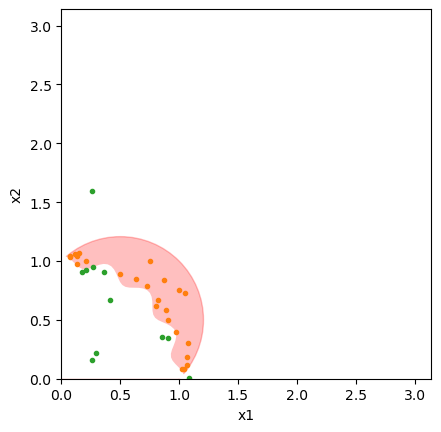

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)

ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

### Plot path through input space

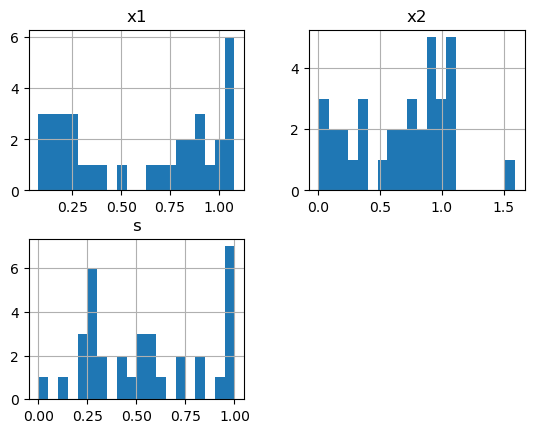

In [6]:
ax = history.hist(["x1", "x2", "s"],bins=20)

<Axes: >

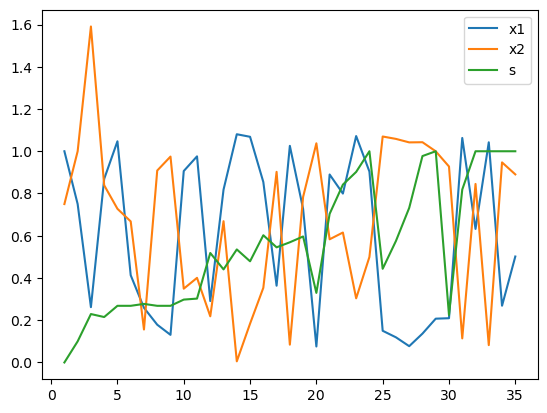

In [7]:
history.plot(y=["x1", "x2", "s"])

## Plot the acqusisition function
Here we plot the acquisition function at a small set of fidelities $[0, 0.5, 1.0]$.

[[0.70621641 0.72569783]]


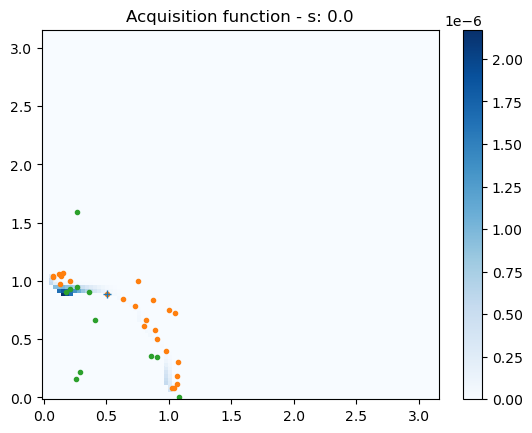

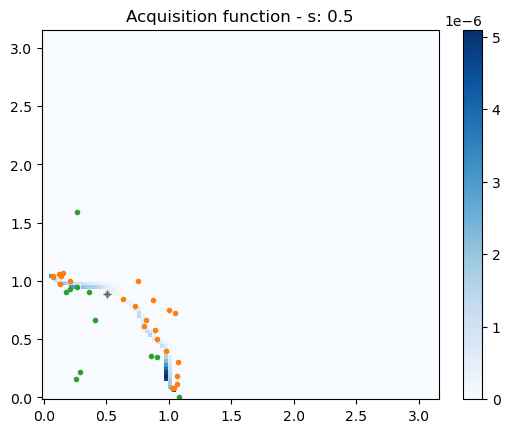

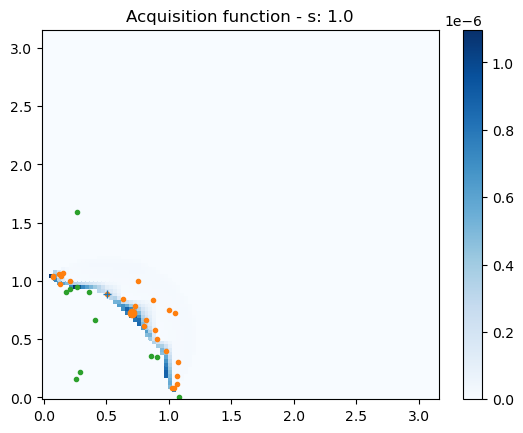

In [8]:
# plot the acquisition function
from xopt.generators.bayesian.objectives import feasibility

bounds = generator.vocs.bounds
model = generator.model

# create mesh over non-fidelity parameters
n = 100
x = torch.linspace(*bounds.T[1], n)
y = torch.linspace(*bounds.T[2], n)
xx, yy = torch.meshgrid(x, y)

# plot function(s) at a single fidelity parameter
fidelities = [0.0, 0.5, 1.0]
for fidelity in fidelities:
    pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()
    pts = torch.cat((torch.ones(pts.shape[0],1)*fidelity, pts), dim=-1)

    acq_func = generator.get_acquisition(model)
    with torch.no_grad():
        acq_pts = pts.unsqueeze(1)
        acq = acq_func(acq_pts)

        fig, ax = plt.subplots()
        c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
        fig.colorbar(c)
        ax.set_title(f"Acquisition function - s: {fidelity}")

        ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
        ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

        ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")


candidate = generator.generate(1)
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")

In [9]:
# examine lengthscale of the first objective
list(model.models[0].named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-25.8965], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(-0.1042, dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0.8571, dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0.9434, 1.4519, 1.5700]], dtype=torch.float64, requires_grad=True))]

In [10]:
# dump results to fiel
X.options.dump_file = "results.yaml"
X.dump_state()